# Stroke Project

# Goals
* Discover the drivers that increase the risk factor of stroke
* Use drivers to develop a machine learning model to predict weather or not a patient has had a stroke.
* Use findings to see what preventitave measures if any can be taken to decrease the risk of stroke

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import wrangle as w
import explore as e
import model as m

from sklearn.metrics import recall_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Decision Tree and Model Evaluation Imports
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



# Acquire
* Data acquired from kaggle on 12-13-2022
    https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?select=healthcare-dataset-stroke-data.csv
* Data contains 5110 rows and 12 columns
* Each row represents a patient and information about the patient
* Each column representa a features related to the patient

In [3]:
# acquire data from csv file
df= w.get_stroke_data()

# Prepare
prepare actions:
  * removed columns with unnecessary information
  * renamed columns and values
  * 211 null values where found and will be imputed after split
  * Outliers have not been removed
  * Encoded categorical variables
  * Split data into train, validate and test:
        (Approximately: train 56%, validate 24%, test 20%)

  * impute 211 null values under BMI column with median due to the right skewness of feature 
  
  * Continuous variables will be scaled before modeling.

In [4]:
# prepare data
df = w.data_prep(df)

In [5]:
# split data and impute bmi by mean
train, validate, test = w.split_and_impute_data(df, 'stroke')

# Data Dictionary

| Feature    | Description    | 
| :------------- | -------------: | 
|      id     |   unique identifier      | 
|   gender       |    Gender of patient Male or Female or Other     | 
| age|     age of the patient     | 
|      hypertension    |     If a patient has hypertension  (1 = yes, 0 = no)  | 
|      hear_disease     |     If a patient has any heart diseases  (1 = yes, 0 = no)  | 
|       ever_married   |   If a patient has ever been married (1 = yes, 0 = no)      | 
|    work_type       |    The work type of patient. *Children are under children category     | 
|  residence_type        |     If a patient residence is  rural of urban   | 
|   avg_glucose_level        |    average glucose level in blood     | 
|     bmi     |   body mass index of patient      | 
|   smoking_status       |    smoking status of patient * Unknown represent the information was unavailable     | 
|          |         | 

# Explore

# 1. What is the percent of patients who have a stroke?


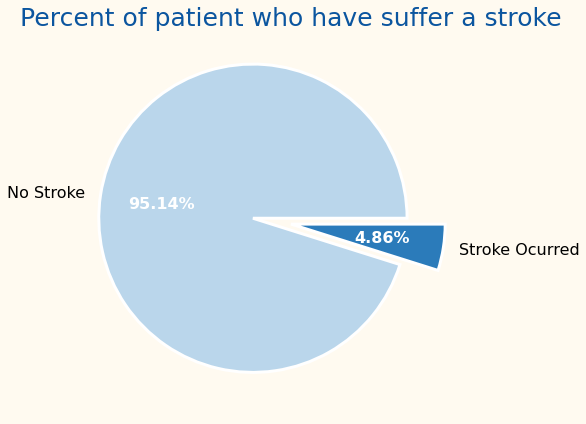

In [6]:
# obtain visualization for percent of patients who have suffer a stroke
e.viz_stroke_percentage(train)

***About 5 % of our patients have suffer a stroke***

# 2. Does the presense of hypertension increase the risk of stroke?


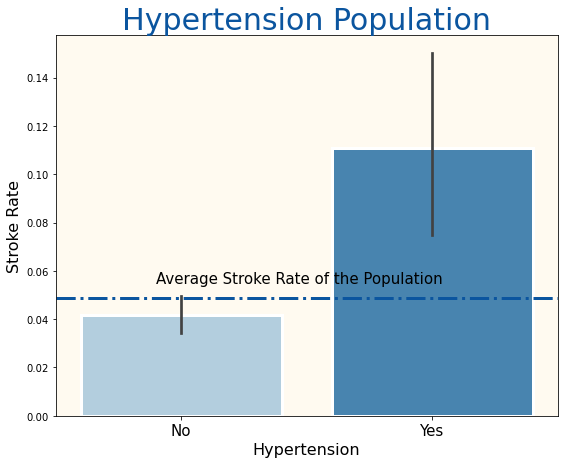

In [7]:
# obtain visualization for hypertension vs stroke
e.viz_hypertension_vs_stroke(train)

***It appears that patients with hypertension tend to have a higher stroke rate than patients without hypertension***

### I will now conduct a chi-square test to determine if there is an association between hypertension  and stroke.

* The confidence interval is 95%
* Alpha is set to 0.05

$H_0$ : Hypertension is **independent**   of stroke.

$H_a$: Hypertension is **dependent** of stroke.

In [8]:
# obtain chi square test
e.chi_square_test(train,'stroke', 'hypertension')

 Chi-Square:24.45069324334392
 p-value:7.623607564219725e-07


Since the p-value is less than alpha we reject the null hypothesis. There is evidence to support that hypertention has an association with stroke. I believe that hypertention is a driver of stroke. Adding an encoded version of this feature to the model will likely increase the mode's accuracy.

# 3. Are patients with a heart condition more at risk of stroke than patients with hypertension?

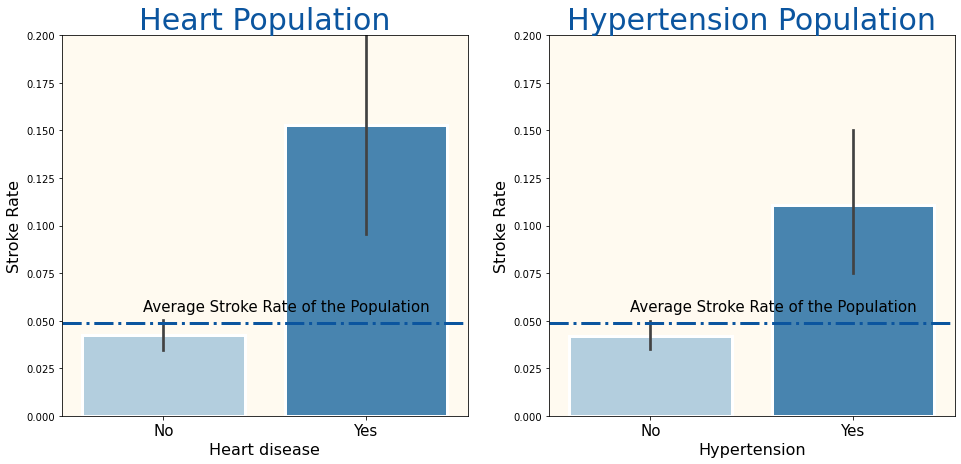

In [9]:
# obtain visualization for heart disease populatin vs stroke and hypertension population vs stroke
e. viz_heart_hyper_stroke(train)

***It appears that patients with a heart condition tend to have a higher stroke rate than patients with hypertension***

### I will now conduct a chi-square test to determine if there is an association between heart condition  and stroke.

* The confidence interval is 95%
* Alpha is set to 0.05

$H_0$: Patients with a heart condition is **independent**   of stroke.

$H_a$: Patients with a heart condition **dependent** of stroke.

In [10]:
# obtain chi square test
e.chi_square_test(train,'stroke', 'heart_disease')

 Chi-Square:36.73001998146243
 p-value:1.356740136221253e-09


Since the p-value is less than alpha we reject the null hypothesis. There is evidence to support that patients with heart disease has an association with stroke. I believe that heart disease is a driver of stroke. Adding an encoded version of this feature to the model will likely increase the mode's accuracy.

# 4. Controling for gender of a patient, does heart disease increases risk of stroke?

In [11]:
# create subgroups for male and female
male_subset = train[train.gender_Male==1]
female_subset = train[train.gender_Male==0]

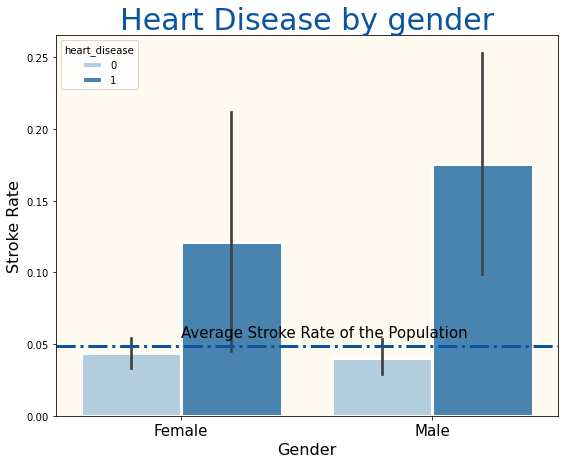

In [12]:
# obtain visualization controling for gender heart disease vs stroke
e.viz_gender_heart_stroke(train)

***It appears that males with hypertension have an above average stroke rate.
Also males with hypertensio have a higher stroke rate than females***

### I will now conduct a chi-square test  is the male population with heart disease associated with stroke.

* The confidence interval is 95%
* Alpha is set to 0.05

$H_0$ : Males with hypertension is **independent**   of stroke.

$H_a$: Males with hypertension is **dependent** of stroke.

In [13]:
e.chi_square_test(male_subset,'stroke', 'heart_disease')


 Chi-Square:29.08260992156263
 p-value:6.935676062013279e-08


Since the p-value is less than alpha we reject the null Hypothesis. There is evidence to support that males a heart disease has an association with stroke.  Adding an encoded version of this feature to the model will likely increase the mode's accuracy.

### I will now conduct a chi-square test  is the female population with heart disease associated with stroke.
* The confidence interval is 95%
* Alpha is set to 0.05

$H_0$ : Females with hypertension is **independent**   of stroke.

$H_a$: Females with hypertension is **dependent** of stroke.

In [14]:
e.chi_square_test(female_subset,'stroke', 'heart_disease')

 Chi-Square:6.8306066361801525
 p-value:0.008960882580754448


Since the p-value is less than alpha we reject the null Hypothesis. There is evidence to support that females with a heart diseas has an association with stroke. Adding an encoded version of this feature to the model will likely increase the mode's accuracy.

# 5. Is age a driver of stroke?

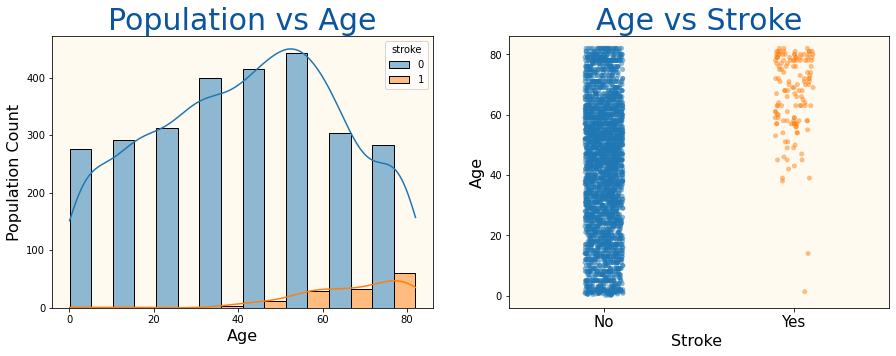

In [15]:
# obtain graph age vs stroke
e.viz_age_vs_stroke(train)

***It seems that with as our patients age increases so does the instances of occurance of a stroke.***

### I will conduct a t-test to determine if the population who has suffer a stroke has a higher mean age thatn the population who has not had a stoke occurance.
* The confidence interval is 95%
* Alpha is set to 0.05
* This will be a Independent t-test

$H_0$ : The mean age of patients who have suffer a stroke <= to the mean age of patients who have not suffer a stroke

$H_a$: The mean age of patients who have suffer a stroke > to the mean age of patients who have not suffer a stroke


In [16]:
# obtain ttest for age vs stroke
e.ttest(train,'stroke','age')

t-stat 20.108050826301564
p-value 5.1422688960466496e-48


Since the p-value/2 is less than alpha we reject the null Hypothesis. There is evidence to support that patients who suffer a stroke  on average are older than patients who have not suffer a stroke. Based on this statistical finding I believe that age is a driver of stroke. Adding an scaled version of this feature to the model will likely increase the model ability to predict home value.

# 6. Do patients who have ever been married suffer more strokes than patients that have not been married

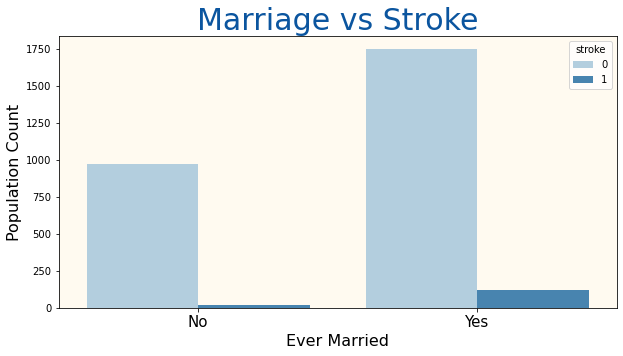

In [17]:
# visualization for patients who have been married vs stroke
e.viz_marriage_vs_stroke(train)

***There seems to be a slight increase in stroke for those patients who have been married.***

### I will now conduct a chi-square test  if patients who have been married is associated with stroke.

* The confidence interval is 95%
* Alpha is set to 0.05

$H_0$ : Patients who have been married are **independent**   of stroke.

$H_a$: Patients who have been married are not **dependent** of stroke.

In [18]:
e.chi_square_test(train, 'stroke','ever_married_Yes')

 Chi-Square:33.01784652416314
 p-value:9.131679279313294e-09


The p-value is less than alpha and we reject the null hypothesis. There is evidence to support that patients who have been married has an association with stroke. I believe that marriage is a driver of stroke. Adding an encoded version of this feature to the model will likely increase the mode's accuracy.

# Exploration Summary

* 4.86% of our patient populatin has suffer a stroke
* Patients with hypertension have an increase in stroke rate
* Patients with heart disease have an increase in stroke rate
* Patients wih heart disease have a larger increase in stroke rate than patients with hypertension
* The male gender of our patients that have heart disease have a higher stroke rate than the female gender
* The patients age is a driver of stroke
* Patients who have been married have a slight increase in stroke rate.

# Features that will be included in my model:

The following features where found significant trough exploration and statistical testing and will be kept for modeling:
* hypertension 
* heart_disease
* gender_Male (encoded)
* age (scaled)
* ever_married_Yes (encoded)

Target variable: Stroke

In [19]:
# save features kept for modeling
modeling_features = ['hypertension','heart_disease','gender_Male','age','ever_married_Yes', 'stroke']

# Features that will be not included in my model:

The following features will not be used for this iteration of modeling:
* work_type
* residence_type
* avg_glucose_level
* bmi
* smoking_status


# Modeling:
* Accuracy is the metric use in the models and a secondary metric will be recall
    * Accuracy helps gauge the percentage of correct predictions
    * Recall helps to prevent Type II error a False Negative:
        * Type II error: A patients is predicted to not be at risk of stroke and has a stroke occurance.
* Patients who have suffer a stroke makeup 4.86% of the data
* 95.14% will be the baseline
* I will evaluate my top model on train and validate data
* The model that performs the best will then be evaluated on test data

In [20]:
X_train,y_train,X_validate,y_validate, X_test, y_test= m.model_prep(train,validate,test,modeling_features)

In [21]:
# run models and get results
models_metrics_df = m.models_metrics(X_train,y_train, X_validate, y_validate)
models_metrics_df

,Model,specs,train_accuracy,validate_accuracy,train_recall,validate_recall
0,Decision Tree,Max Depth = 6,0.952115,0.951915,0.035971,0.033333
1,RandomForest,"Max Depth = 8,min_sample_leaf =1",0.956309,0.945395,0.129496,0.016667
2,KNN neighbor,"neighbors =7, weights= uniform",0.952115,0.951100,0.014388,0.016667
3,Logistic Regression,solver = saga,0.951416,0.951100,0.000000,0.000000


# Modeling Summary
#### In train data:

* Model:Random Forest performed best in both accuracy and recall
* All models except Logistic Regression were slightly above baseline in terms of accuracy
* Recall is minimally improved by Random Forest

#### In validate data:

* Decision Tree perfromed best and was the only model that was above baseline in terms of accuracy
* Recall is minimally improved by Decision Tree
    